In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [3]:
import torch
torch.cuda.is_available()

True

# Data Test 0

In [4]:
import numpy as np
from numpy import pi
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)

data0Path = r'../../dataset/data0test.txt'
data0Label = r'../../dataset/data0testlabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data1 = list(zip(dataCoords, 2*dataLabels-1))

In [5]:
from pandas.core.common import flatten
import torch

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data1), size=100)

X= [np.array(list(flatten([data1[j][0],data1[j][0]]))) for j in data_ixs]
y = [data1[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;
apram=8.0*pi
feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(apram*Parameter('x[0]'),0)
feature_map.rx(apram*Parameter('x[1]'),1)
feature_map.rx(apram*Parameter('x[2]'),2)
feature_map.rx(apram*Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)
ansatz.cx(0,1)
ansatz.cx(2,3)
ansatz.ry(param_y[8],1)
ansatz.ry(param_y[9],2)
ansatz.rz(param_y[10],1)
ansatz.rz(param_y[11],2)
ansatz.cx(1,2)





qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.3*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

In [6]:
def binary(x):
    return ('0'*(4-len('{:b}'.format(x) ))+'{:b}'.format(x))
def firsttwo(x):
    return x[:2]
parity = lambda x: firsttwo(binary(x)).count('1') % 2

In [7]:
# define optimizer and loss function
optimizer = LBFGS(model2.parameters())
f_loss = MSELoss(reduction='sum')

# start training
model2.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss
    return loss

# run optimizer
optimizer.step(closure)

C:\Users\Saesun Kim\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


51.92824172973633
50.9081916809082
50.545166015625
50.181270599365234
50.11674499511719
50.09400177001953
50.088401794433594
50.08664321899414
50.08450698852539
50.083641052246094
50.08347702026367
50.08342742919922
50.08342361450195
50.08333206176758
50.08314514160156
50.082435607910156
50.14287567138672
52.4677734375
51.022762298583984
58.170654296875


tensor(51.9282, grad_fn=<AddBackward0>)

Accuracy: 0.52


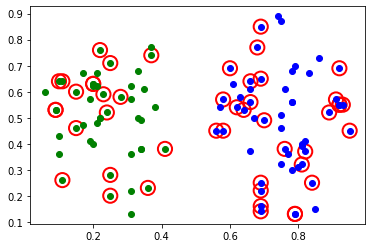

In [8]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

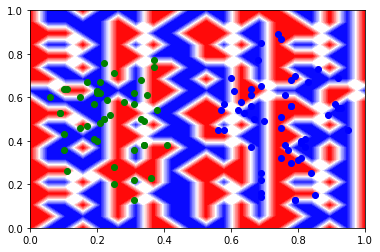

In [9]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=20)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

In [10]:
qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.3*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

# define optimizer and loss function
optimizer = optim.SGD(model2.parameters(),lr=1)
f_loss = MSELoss(reduction='sum')

# start training
model2.train()   # set model to training mode
epochs = 50     # set number of epochs

# define objective function
for epoch in range(epochs):
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss

    # run optimizer
    optimizer.step()


51.1309928894043
54.0987663269043
58.23194885253906
51.383731842041016
50.30381393432617
50.794063568115234
51.203826904296875
59.904869079589844
53.96416091918945
50.11857604980469
51.59507369995117
53.489315032958984
51.71308898925781
53.118350982666016
50.64188003540039
50.481502532958984
55.77637481689453
53.583988189697266
51.9489860534668
52.98368835449219
50.50165557861328
50.285091400146484
50.19194412231445
50.37452697753906
50.1515998840332
50.01307678222656
50.007659912109375
50.00581741333008
50.004825592041016
50.00416946411133
50.003692626953125
50.00334930419922
50.00303649902344
50.00279235839844
50.002593994140625
50.00240707397461
50.00223922729492
50.00210952758789
50.00198745727539
50.00187301635742
50.001773834228516
50.00166702270508
50.001583099365234
50.00149154663086
50.00141906738281
50.0013427734375
50.00128173828125
50.001216888427734
50.00115203857422
50.00110626220703


Accuracy: 0.43


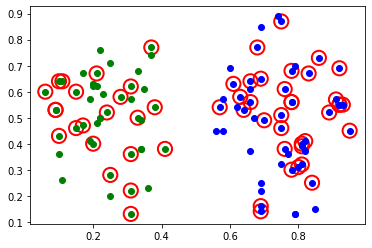

In [11]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

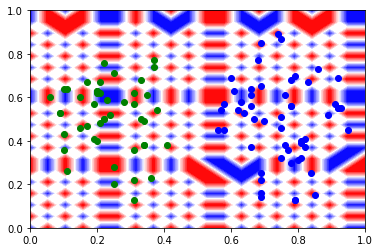

In [12]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=20)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

In [13]:
qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.3*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define optimizer and loss function
optimizer = optim.Adam(model2.parameters(), lr=0.1)
f_loss = MSELoss(reduction='sum')

# start training
model2.train()   # set model to training mode
epochs = 100     # set number of epochs

# define objective function
for epoch in range(epochs):
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss

    # run optimizer
    optimizer.step()

50.69569396972656
50.39791488647461
50.26168441772461
50.19948196411133
50.158348083496094
50.12998962402344
50.116024017333984
50.11306381225586
50.1148796081543
50.11602783203125
50.11296081542969
50.104278564453125
50.090667724609375
50.074100494384766
50.05680847167969
50.0412712097168
50.029354095458984
50.02073287963867
50.01352310180664
50.00722122192383
50.00312042236328
50.001991271972656
50.00351333618164
50.00691223144531
50.01076889038086
50.01368713378906
50.01517105102539
50.015316009521484
50.01465606689453
50.013710021972656
50.012691497802734
50.011619567871094
50.01042556762695
50.00897979736328
50.0073127746582
50.00551223754883
50.0037841796875
50.0023307800293
50.00124740600586
50.00056457519531
50.000221252441406
50.00014877319336
50.00026321411133
50.00047302246094
50.000736236572266
50.00099182128906
50.0012092590332
50.001407623291016
50.00153732299805
50.001617431640625
50.00160217285156
50.00150680541992
50.0013542175293
50.00113296508789
50.00088882446289
50

Accuracy: 0.5


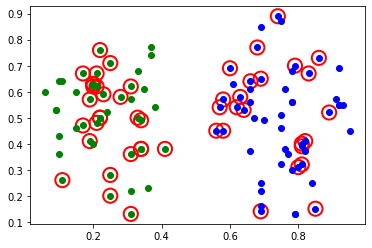

In [14]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

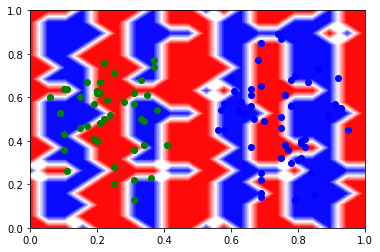

In [15]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=20)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)